In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import gc, math

from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

##### Set the size and styles of graphs

In [2]:
sns.set(rc={'figure.figsize':(11,8)})
sns.set(style="whitegrid")

### Read the dataset
Data is given in different CSV files which we will need to merge afterwards. 

`train.csv` only contains the ID of the building and meter related information including our target variable to be predicted (`meter_reading`). This `building_id` is foreign key in `building_metadata.csv`. All the information related to the buildings are given in this file. 


Same goes for `weather_train.csv` and `building_metadata.csv` files with common column (foreign key) `site_id`. So all three files are related and we will have to join these tables later

In [3]:
%%time
metadata_df = pd.read_csv('/kaggle/input/ashrae-energy-prediction/building_metadata.csv')
train_df = pd.read_csv('/kaggle/input/ashrae-energy-prediction/train.csv', parse_dates=['timestamp'])
test_df = pd.read_csv('/kaggle/input/ashrae-energy-prediction/test.csv', parse_dates=['timestamp'])
weather_train_df = pd.read_csv('/kaggle/input/ashrae-energy-prediction/weather_train.csv', parse_dates=['timestamp'])
weather_test_df = pd.read_csv('/kaggle/input/ashrae-energy-prediction/weather_test.csv', parse_dates=['timestamp'])

CPU times: user 40.1 s, sys: 7.73 s, total: 47.9 s
Wall time: 47.3 s


In [4]:
train_df.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01,0.0
1,1,0,2016-01-01,0.0
2,2,0,2016-01-01,0.0
3,3,0,2016-01-01,0.0
4,4,0,2016-01-01,0.0


In [5]:
weather_train_df.shape

(139773, 9)

In [6]:
test_df.head()

,row_id,building_id,meter,timestamp
0,0,0,0,2017-01-01
1,1,1,0,2017-01-01
2,2,2,0,2017-01-01
3,3,3,0,2017-01-01
4,4,4,0,2017-01-01


### Align timestamps
Timestap data is not in their local time. As energy consumptions are related to the local time, an alighment is nescessary before using timestamp. 

The credit goes to [this kernel](https://www.kaggle.com/nz0722/aligned-timestamp-lgbm-by-meter-type) for the idea. Refer it for more details and explanation about below code.

In [7]:
weather = pd.concat([weather_train_df,weather_test_df],ignore_index=True)
weather_key = ['site_id', 'timestamp']

temp_skeleton = weather[weather_key + ['air_temperature']].drop_duplicates(subset=weather_key).sort_values(by=weather_key).copy()

# calculate ranks of hourly temperatures within date/site_id chunks
temp_skeleton['temp_rank'] = temp_skeleton.groupby(['site_id', temp_skeleton.timestamp.dt.date])['air_temperature'].rank('average')

# create a dataframe of site_ids (0-16) x mean hour rank of temperature within day (0-23)
df_2d = temp_skeleton.groupby(['site_id', temp_skeleton.timestamp.dt.hour])['temp_rank'].mean().unstack(level=1)

# Subtract the columnID of temperature peak by 14, getting the timestamp alignment gap.
site_ids_offsets = pd.Series(df_2d.values.argmax(axis=1) - 14)
site_ids_offsets.index.name = 'site_id'

def timestamp_align(df):
    df['offset'] = df.site_id.map(site_ids_offsets)
    df['timestamp_aligned'] = (df.timestamp - pd.to_timedelta(df.offset, unit='H'))
    df['timestamp'] = df['timestamp_aligned']
    del df['timestamp_aligned']
    return df

In [8]:
weather_train_df.tail()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
139768,15,2016-12-31 19:00:00,3.0,NaN,-8.0,NaN,NaN,180.0,5.7
139769,15,2016-12-31 20:00:00,2.8,2.0,-8.9,NaN,1007.4,180.0,7.7
139770,15,2016-12-31 21:00:00,2.8,NaN,-7.2,NaN,1007.5,180.0,5.1
139771,15,2016-12-31 22:00:00,2.2,NaN,-6.7,NaN,1008.0,170.0,4.6
139772,15,2016-12-31 23:00:00,1.7,NaN,-5.6,-1.0,1008.5,180.0,8.8


In [9]:
weather_train_df = timestamp_align(weather_train_df)
weather_test_df = timestamp_align(weather_test_df)

In [10]:
del weather 
del df_2d
del temp_skeleton
del site_ids_offsets

In [11]:
weather_train_df.tail()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,offset
139768,15,2016-12-31 13:00:00,3.0,NaN,-8.0,NaN,NaN,180.0,5.7,6
139769,15,2016-12-31 14:00:00,2.8,2.0,-8.9,NaN,1007.4,180.0,7.7,6
139770,15,2016-12-31 15:00:00,2.8,NaN,-7.2,NaN,1007.5,180.0,5.1,6
139771,15,2016-12-31 16:00:00,2.2,NaN,-6.7,NaN,1008.0,170.0,4.6,6
139772,15,2016-12-31 17:00:00,1.7,NaN,-5.6,-1.0,1008.5,180.0,8.8,6


### Fill NaNs in weather data by interpolation

In [12]:
weather_train_df.isna().sum()

site_id                   0
timestamp                 0
air_temperature          55
cloud_coverage        69173
dew_temperature         113
precip_depth_1_hr     50289
sea_level_pressure    10618
wind_direction         6268
wind_speed              304
offset                    0
dtype: int64

In [13]:
weather_test_df.isna().sum()

site_id                    0
timestamp                  0
air_temperature          104
cloud_coverage        140448
dew_temperature          327
precip_depth_1_hr      95588
sea_level_pressure     21265
wind_direction         12370
wind_speed               460
offset                     0
dtype: int64

In [14]:
weather_train_df = weather_train_df.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))

In [15]:
weather_test_df = weather_test_df.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))

In [16]:
weather_train_df.isna().sum()

site_id                   0
timestamp                 0
air_temperature           0
cloud_coverage        17228
dew_temperature           0
precip_depth_1_hr     26273
sea_level_pressure     8755
wind_direction            0
wind_speed                0
offset                    0
dtype: int64

In [17]:
weather_test_df.isna().sum()

site_id                   0
timestamp                 0
air_temperature           0
cloud_coverage        33146
dew_temperature           0
precip_depth_1_hr     51807
sea_level_pressure    17241
wind_direction            0
wind_speed                0
offset                    0
dtype: int64

In [18]:
train_df['meter_reading'] = np.log1p(train_df['meter_reading'])

In [19]:
weather_train_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,offset
0,0,2015-12-31 19:00:00,25.0,6.0,20.0,-1.0,1019.7,0.0,0.0,5
1,0,2015-12-31 20:00:00,24.4,4.0,21.1,-1.0,1020.2,70.0,1.5,5
2,0,2015-12-31 21:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0,5
3,0,2015-12-31 22:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0,5
4,0,2015-12-31 23:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6,5


In [20]:
## Function to reduce the memory usage
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [21]:
le = LabelEncoder()
metadata_df['primary_use'] = le.fit_transform(metadata_df['primary_use'])

In [22]:
metadata_df = reduce_mem_usage(metadata_df)
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)
weather_train_df = reduce_mem_usage(weather_train_df)
weather_test_df = reduce_mem_usage(weather_test_df)

Mem. usage decreased to  0.02 Mb (74.9% reduction)
Mem. usage decreased to 250.63 Mb (59.4% reduction)
Mem. usage decreased to 596.49 Mb (53.1% reduction)
Mem. usage decreased to  3.20 Mb (70.0% reduction)
Mem. usage decreased to  6.35 Mb (70.0% reduction)


#### Get insights of shapes and first few data rows of all the files

In [23]:
print (f'Training data shape: {train_df.shape}')
print (f'Weather training shape: {weather_train_df.shape}')
print (f'Weather training shape: {weather_test_df.shape}')
print (f'Weather testing shape: {metadata_df.shape}')
print (f'Test data shape: {test_df.shape}')

Training data shape: (20216100, 4)
Weather training shape: (139773, 10)
Weather training shape: (277243, 10)
Weather testing shape: (1449, 6)
Test data shape: (41697600, 4)


In [24]:
train_df.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01,0.0
1,1,0,2016-01-01,0.0
2,2,0,2016-01-01,0.0
3,3,0,2016-01-01,0.0
4,4,0,2016-01-01,0.0


In [25]:
weather_train_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,offset
0,0,2015-12-31 19:00:00,25.000000,6.0,20.00000,-1.0,1019.5,0.0,0.000000,5
1,0,2015-12-31 20:00:00,24.406250,4.0,21.09375,-1.0,1020.0,70.0,1.500000,5
2,0,2015-12-31 21:00:00,22.796875,2.0,21.09375,0.0,1020.0,0.0,0.000000,5
3,0,2015-12-31 22:00:00,21.093750,2.0,20.59375,0.0,1020.0,0.0,0.000000,5
4,0,2015-12-31 23:00:00,20.000000,2.0,20.00000,-1.0,1020.0,250.0,2.599609,5


In [26]:
metadata_df.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,0,7432,2008.0,NaN
1,0,1,0,2720,2004.0,NaN
2,0,2,0,5376,1991.0,NaN
3,0,3,0,23685,2002.0,NaN
4,0,4,0,116607,1975.0,NaN


In [27]:
test_df.head()

,row_id,building_id,meter,timestamp
0,0,0,0,2017-01-01
1,1,1,0,2017-01-01
2,2,2,0,2017-01-01
3,3,3,0,2017-01-01
4,4,4,0,2017-01-01


#### Merge necessary files
As mentioned previously, to get a single dataframe for training and a single data frame for testing with all the feature included, we need to join the tables/files which are related by foreign keys. Let's first merge/join training data.

In [28]:
train_df.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01,0.0
1,1,0,2016-01-01,0.0
2,2,0,2016-01-01,0.0
3,3,0,2016-01-01,0.0
4,4,0,2016-01-01,0.0


In [29]:
%%time
full_train_df = train_df.merge(metadata_df, on='building_id', how='left')
full_train_df = full_train_df.merge(weather_train_df, on=['site_id', 'timestamp'], how='left')

CPU times: user 6.92 s, sys: 4.84 s, total: 11.8 s
Wall time: 10.2 s


In [30]:
# %%time
# train_metadata_df = train_df.join(other=metadata_df.set_index('building_id'), on='building_id', how='left', lsuffix='_l', rsuffix='_r')
# full_train_df = train_metadata_df.merge(right=weather_train_df, how='left')

Drop all NaN rows which are generated by timestamp alignment

In [31]:
# full_train_df = full_train_df.loc[~(full_train_df['air_temperature'].isnull() & full_train_df['cloud_coverage'].isnull() & full_train_df['dew_temperature'].isnull() & full_train_df['precip_depth_1_hr'].isnull() & full_train_df['sea_level_pressure'].isnull() & full_train_df['wind_direction'].isnull() & full_train_df['wind_speed'].isnull() & full_train_df['offset'].isnull())]

In [32]:
full_train_df.shape

(20216100, 17)

#### Reducing the memory usage
Let's delete unnecessary dataframes from memory to lower the memory usage

In [33]:
# Delete unnecessary dataframes to decrease memory usage
del train_df
del weather_train_df
gc.collect()

0

Now let's change the data types of necessary feature columns based on the range of the data values. This will lower the data usage. But **how**? Let's see. For example the datatype of feature `building_id` is `int64` but based on the range of this feature, it can be accomodated in lower range i.e. `int16`. So this will decrease the memory usage.

#### Let's do the same for test data

In [34]:
%%time
# full_test_df = test_df.merge(metadata_df, on='building_id', how='left')
# full_test_df = full_test_df.merge(weather_test_df, on=['site_id', 'timestamp'], how='left')
full_test_df = test_df.merge(metadata_df, on='building_id', how='left')
full_test_df = full_test_df.merge(weather_test_df, on=['site_id', 'timestamp'], how='left')

CPU times: user 12.9 s, sys: 12.6 s, total: 25.5 s
Wall time: 22.6 s


In [35]:
# full_test_df = full_test_df.loc[~(full_test_df['air_temperature'].isnull() & full_test_df['cloud_coverage'].isnull() & full_test_df['dew_temperature'].isnull() & full_test_df['precip_depth_1_hr'].isnull() & full_test_df['sea_level_pressure'].isnull() & full_test_df['wind_direction'].isnull() & full_test_df['wind_speed'].isnull() & full_test_df['offset'].isnull())]

In [36]:
full_test_df.shape

(41697600, 17)

#### Reducing the memory usage
Let's delete unnecessary dataframes from memory to lower the memory usage

In [37]:
# Delete unnecessary dataframes to decrease memory usage
del metadata_df
del weather_test_df
del test_df
gc.collect()

0

Now let's change the data types of necessary feature columns based on the range of the data values. This will lower the data usage. But **how**? Let's see. For example the datatype of feature `building_id` is `int64` but based on the range of this feature, it can be accomodated in lower range i.e. `int16`. So this will decrease the memory usage.

## Exploratory Data Analysis
Exploratory Data Analysis (EDA) is an open-ended process where we calculate statistics and make figures to find trends, anomalies, patterns, or relationships within the data.

### Distribition of primary usage of buildings

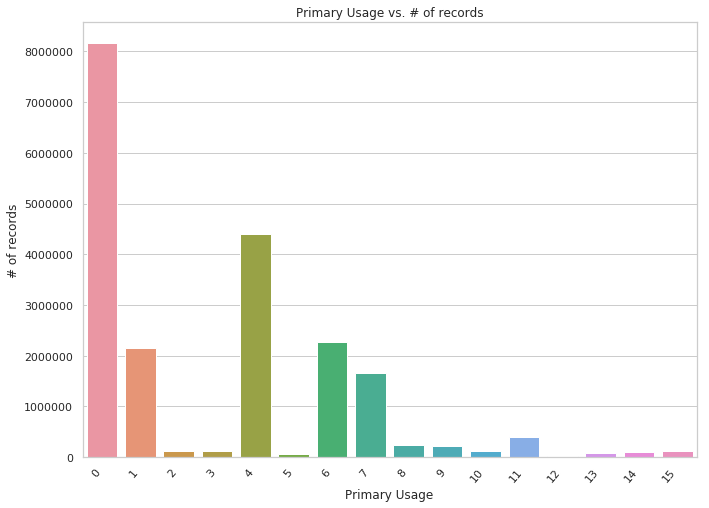

In [38]:
ax = sns.barplot(pd.unique(full_train_df['primary_use']), full_train_df['primary_use'].value_counts())
ax.set(xlabel='Primary Usage', ylabel='# of records', title='Primary Usage vs. # of records')
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
plt.show()

### Distribution of meter types

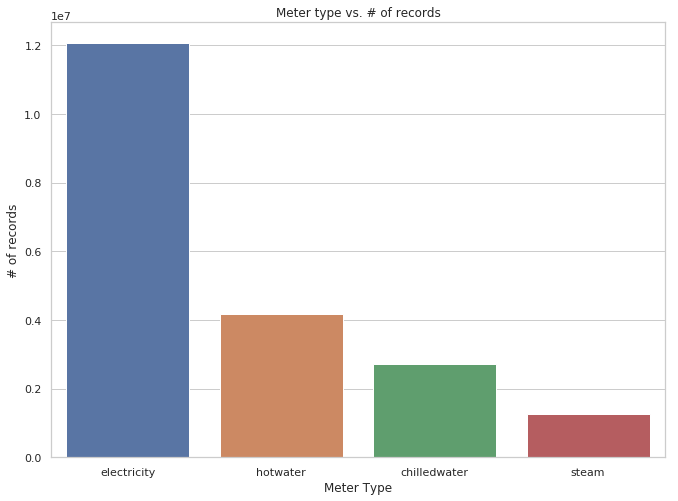

In [39]:
meter_types = {0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'}
ax = sns.barplot(np.vectorize(meter_types.get)(pd.unique(full_train_df['meter'])), full_train_df['meter'].value_counts())
ax.set(xlabel='Meter Type', ylabel='# of records', title='Meter type vs. # of records')
plt.show()

### Average meter reading for training dataset

In [40]:
# Average meter reading
print (f'Average meter reading: {full_train_df.meter_reading.mean()} kWh')

Average meter reading: nan kWh


### Distribution of meter readings for each meter type

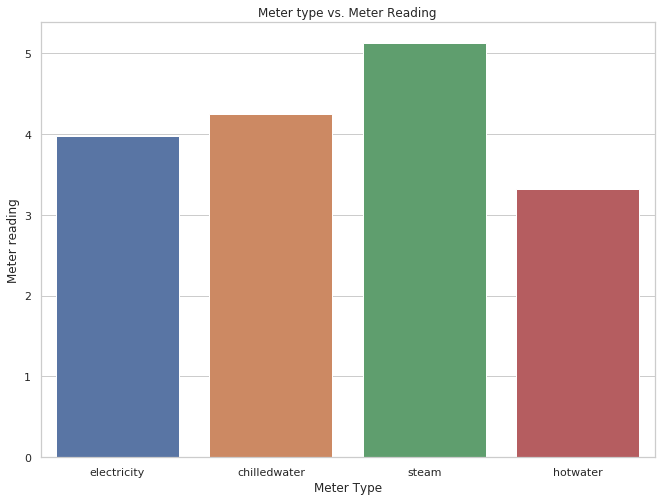

In [41]:
ax = sns.barplot(np.vectorize(meter_types.get)(full_train_df.groupby(['meter'])['meter_reading'].mean().keys()), full_train_df.groupby(['meter'])['meter_reading'].mean())
ax.set(xlabel='Meter Type', ylabel='Meter reading', title='Meter type vs. Meter Reading')
plt.show()

### Distribution of buildings built in each year for both training and test datasets

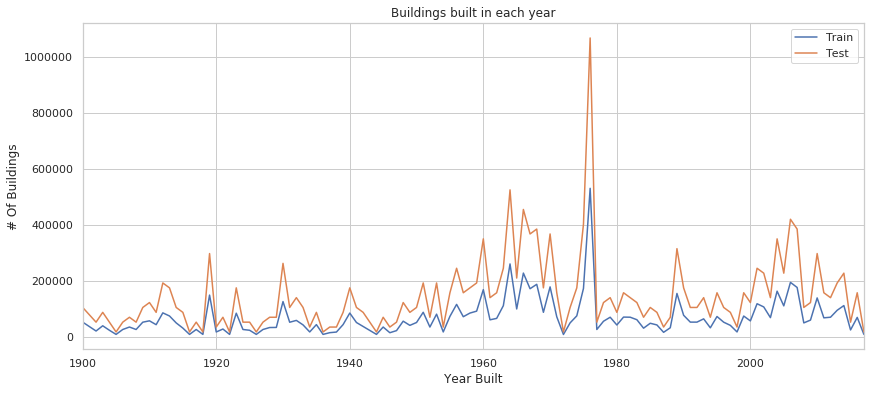

In [42]:
fig, ax = plt.subplots(1,1,figsize=(14, 6))
ax.set(xlabel='Year Built', ylabel='# Of Buildings', title='Buildings built in each year')
full_train_df['year_built'].value_counts(dropna=False).sort_index().plot(ax=ax)
full_test_df['year_built'].value_counts(dropna=False).sort_index().plot(ax=ax)
ax.legend(['Train', 'Test']);

### Distribution of square feet area of buildings

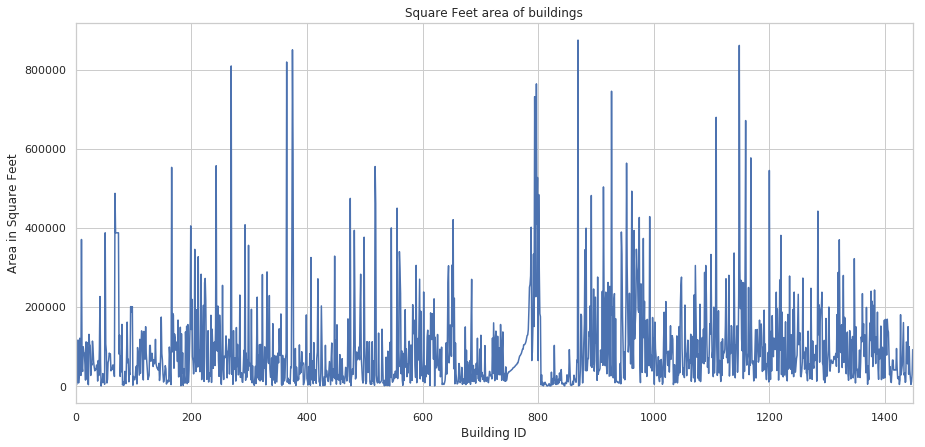

In [43]:
fig, ax = plt.subplots(1,1,figsize=(15, 7))
full_train_df.groupby(['building_id'])['square_feet'].mean().plot(ax=ax)
ax.set(xlabel='Building ID', ylabel='Area in Square Feet', title='Square Feet area of buildings')
plt.show()

## Feature Engineering
The joined dataframe (full_train_df) now has 20,216,100 rows, and 16 features in training dataset.

### Analysing missing data
First let's count and fill missing data in training datasets

In [44]:
pd.DataFrame(full_train_df.isna().sum().sort_values(ascending=False), columns=['NaN Count'])

,NaN Count
floor_count,16709167
year_built,12127645
precip_depth_1_hr,1749549
sea_level_pressure,882646
cloud_coverage,580004
air_temperature,103451
wind_speed,103451
offset,103451
dew_temperature,103451
wind_direction,103451


Missing data can be filled in many ways. Here are few techniques to fill missing values: 

* Ignore the data row
* Back-fill or forward-fill to propagate next or previous values respectively
* Replace with some constant value outside fixed value range-999,-1 etc.
* Replace with mean, median value

For now, we will go with last method. So let's fill all the missing data with it's average(mean) values of corresponding columns.

In [45]:
def mean_without_overflow_fast(col):
    col /= len(col)
    return col.mean() * len(col)

In [46]:
missing_values = (100-full_train_df.count() / len(full_train_df) * 100).sort_values(ascending=False)

In [47]:
%%time
missing_features = full_train_df.loc[:, missing_values > 0.0]
missing_features = missing_features.apply(mean_without_overflow_fast)

CPU times: user 2.57 s, sys: 2.82 s, total: 5.39 s
Wall time: 3.15 s


In [48]:
for key in full_train_df.loc[:, missing_values > 0.0].keys():
    if key == 'year_built' or key == 'floor_count':
        full_train_df[key].fillna(math.floor(missing_features[key]), inplace=True)
        full_test_df[key].fillna(math.floor(missing_features[key]), inplace=True)
    else:
        full_train_df[key].fillna(missing_features[key], inplace=True)
        full_test_df[key].fillna(missing_features[key], inplace=True)

In [49]:
full_train_df.tail()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,offset
20216095,1444,0,2016-12-31 23:00:00,2.277344,15,1,19619,1914.0,4.0,15.992188,2.75,7.753906,1.255859,1016.0,171.25,3.376953,6.187032
20216096,1445,0,2016-12-31 23:00:00,1.761719,15,0,4298,1968.0,4.0,15.992188,2.75,7.753906,1.255859,1016.0,171.25,3.376953,6.187032
20216097,1446,0,2016-12-31 23:00:00,0.000000,15,1,11265,1997.0,4.0,15.992188,2.75,7.753906,1.255859,1016.0,171.25,3.376953,6.187032
20216098,1447,0,2016-12-31 23:00:00,5.078125,15,4,29775,2001.0,4.0,15.992188,2.75,7.753906,1.255859,1016.0,171.25,3.376953,6.187032
20216099,1448,0,2016-12-31 23:00:00,1.347656,15,6,92271,2001.0,4.0,15.992188,2.75,7.753906,1.255859,1016.0,171.25,3.376953,6.187032


In [50]:
full_test_df.tail()

,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,offset
41697595,41697595,1444,0,2018-05-09 07:00:00,15,1,19619,1914.0,4.0,18.90625,0.0,10.601562,-1.0,1020.5,180.0,2.599609,6.0
41697596,41697596,1445,0,2018-05-09 07:00:00,15,0,4298,1968.0,4.0,18.90625,0.0,10.601562,-1.0,1020.5,180.0,2.599609,6.0
41697597,41697597,1446,0,2018-05-09 07:00:00,15,1,11265,1997.0,4.0,18.90625,0.0,10.601562,-1.0,1020.5,180.0,2.599609,6.0
41697598,41697598,1447,0,2018-05-09 07:00:00,15,4,29775,2001.0,4.0,18.90625,0.0,10.601562,-1.0,1020.5,180.0,2.599609,6.0
41697599,41697599,1448,0,2018-05-09 07:00:00,15,6,92271,2001.0,4.0,18.90625,0.0,10.601562,-1.0,1020.5,180.0,2.599609,6.0


So all the missing values for training and testing data is now filled with the mean of corresponding feature columns.

### Adding few more features

First let's expand timestamp to multiple components

In [51]:
full_train_df['timestamp'].dtype

dtype('<M8[ns]')

In [52]:
full_train_df["timestamp"] = pd.to_datetime(full_train_df["timestamp"])
full_test_df["timestamp"] = pd.to_datetime(full_test_df["timestamp"])

In [53]:
def transform(df):
    df['hour'] = np.uint8(df['timestamp'].dt.hour)
    df['day'] = np.uint8(df['timestamp'].dt.day)
    df['weekday'] = np.uint8(df['timestamp'].dt.weekday)
    df['month'] = np.uint8(df['timestamp'].dt.month)
    df['year'] = np.uint8(df['timestamp'].dt.year-1900)
    
    df['square_feet'] = np.log(df['square_feet'])
    
    return df

In [54]:
full_train_df = transform(full_train_df)
full_test_df = transform(full_test_df)

In [55]:
dates_range = pd.date_range(start='2015-12-31', end='2019-01-01')
us_holidays = calendar().holidays(start=dates_range.min(), end=dates_range.max())
full_train_df['is_holiday'] = (full_train_df['timestamp'].dt.date.astype('datetime64').isin(us_holidays)).astype(np.int8)
full_test_df['is_holiday'] = (full_test_df['timestamp'].dt.date.astype('datetime64').isin(us_holidays)).astype(np.int8)

In [56]:
# Assuming 5 days a week for all the given buildings
full_train_df.loc[(full_train_df['weekday'] == 5) | (full_train_df['weekday'] == 6) , 'is_holiday'] = 1
full_test_df.loc[(full_test_df['weekday']) == 5 | (full_test_df['weekday'] == 6) , 'is_holiday'] = 1

### Removing weired data on site_id 0
As you can see above, this data looks weired until May 20. It is reported in this discussion by @barnwellguy that All electricity meter is 0 until May 20 for site_id == 0. Let's remove these data from training data.

In [57]:
full_train_df.shape

(20216100, 23)

In [58]:
full_train_df = full_train_df.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')

In [59]:
full_train_df.shape

(19869886, 23)

In [60]:
full_test_df = full_test_df.drop(['timestamp'], axis=1)
full_train_df = full_train_df.drop(['timestamp'], axis=1)
print (f'Shape of training dataset: {full_train_df.shape}')
print (f'Shape of testing dataset: {full_test_df.shape}')

Shape of training dataset: (19869886, 22)
Shape of testing dataset: (41697600, 22)


In [61]:
full_train_df.tail()

,building_id,meter,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,...,sea_level_pressure,wind_direction,wind_speed,offset,hour,day,weekday,month,year,is_holiday
20216095,1444,0,2.277344,15,1,9.884254,1914.0,4.0,15.992188,2.75,...,1016.0,171.25,3.376953,6.187032,23,31,5,12,116,1
20216096,1445,0,1.761719,15,0,8.365905,1968.0,4.0,15.992188,2.75,...,1016.0,171.25,3.376953,6.187032,23,31,5,12,116,1
20216097,1446,0,0.000000,15,1,9.329456,1997.0,4.0,15.992188,2.75,...,1016.0,171.25,3.376953,6.187032,23,31,5,12,116,1
20216098,1447,0,5.078125,15,4,10.301424,2001.0,4.0,15.992188,2.75,...,1016.0,171.25,3.376953,6.187032,23,31,5,12,116,1
20216099,1448,0,1.347656,15,6,11.432485,2001.0,4.0,15.992188,2.75,...,1016.0,171.25,3.376953,6.187032,23,31,5,12,116,1


In [62]:
full_train_df.tail()

,building_id,meter,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,...,sea_level_pressure,wind_direction,wind_speed,offset,hour,day,weekday,month,year,is_holiday
20216095,1444,0,2.277344,15,1,9.884254,1914.0,4.0,15.992188,2.75,...,1016.0,171.25,3.376953,6.187032,23,31,5,12,116,1
20216096,1445,0,1.761719,15,0,8.365905,1968.0,4.0,15.992188,2.75,...,1016.0,171.25,3.376953,6.187032,23,31,5,12,116,1
20216097,1446,0,0.000000,15,1,9.329456,1997.0,4.0,15.992188,2.75,...,1016.0,171.25,3.376953,6.187032,23,31,5,12,116,1
20216098,1447,0,5.078125,15,4,10.301424,2001.0,4.0,15.992188,2.75,...,1016.0,171.25,3.376953,6.187032,23,31,5,12,116,1
20216099,1448,0,1.347656,15,6,11.432485,2001.0,4.0,15.992188,2.75,...,1016.0,171.25,3.376953,6.187032,23,31,5,12,116,1


In [63]:
## Reducing memory
full_train_df = reduce_mem_usage(full_train_df)
full_test_df = reduce_mem_usage(full_test_df)
gc.collect()

Mem. usage decreased to 814.82 Mb (21.8% reduction)
Mem. usage decreased to 1789.47 Mb (21.1% reduction)


11265

In [64]:
def degToCompass(num):
    val=int((num/22.5)+.5)
    arr=[i for i in range(0,16)]
    return arr[(val % 16)]

In [65]:
full_train_df['wind_direction'] = full_train_df['wind_direction'].apply(degToCompass)

In [66]:
beaufort = [(0, 0, 0.3), (1, 0.3, 1.6), (2, 1.6, 3.4), (3, 3.4, 5.5), (4, 5.5, 8), (5, 8, 10.8), (6, 10.8, 13.9), 
          (7, 13.9, 17.2), (8, 17.2, 20.8), (9, 20.8, 24.5), (10, 24.5, 28.5), (11, 28.5, 33), (12, 33, 200)]

for item in beaufort:
    full_train_df.loc[(full_train_df['wind_speed']>=item[1]) & (full_train_df['wind_speed']<item[2]), 'beaufort_scale'] = item[0]

In [67]:
# le = LabelEncoder()
# full_train_df['primary_use'] = le.fit_transform(full_train_df['primary_use'])

categoricals = ['site_id', 'building_id', 'primary_use', 'hour', 'weekday', 'meter',  'wind_direction', 'is_holiday']
drop_cols = ['sea_level_pressure', 'wind_speed']
numericals = ['square_feet', 'year_built', 'air_temperature', 'cloud_coverage',
              'dew_temperature', 'precip_depth_1_hr', 'floor_count', 'beaufort_scale']

feat_cols = categoricals + numericals

In [68]:
full_train_df.tail()

,building_id,meter,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,...,wind_direction,wind_speed,offset,hour,day,weekday,month,year,is_holiday,beaufort_scale
20216095,1444,0,2.277344,15,1,9.882812,1914.0,4.0,15.992188,2.75,...,8,3.376953,6.1875,23,31,5,12,116,1,2.0
20216096,1445,0,1.761719,15,0,8.367188,1968.0,4.0,15.992188,2.75,...,8,3.376953,6.1875,23,31,5,12,116,1,2.0
20216097,1446,0,0.000000,15,1,9.328125,1997.0,4.0,15.992188,2.75,...,8,3.376953,6.1875,23,31,5,12,116,1,2.0
20216098,1447,0,5.078125,15,4,10.304688,2001.0,4.0,15.992188,2.75,...,8,3.376953,6.1875,23,31,5,12,116,1,2.0
20216099,1448,0,1.347656,15,6,11.429688,2001.0,4.0,15.992188,2.75,...,8,3.376953,6.1875,23,31,5,12,116,1,2.0


In [69]:
full_train_df = reduce_mem_usage(full_train_df)
gc.collect()

Mem. usage decreased to 833.77 Mb (22.8% reduction)


0

In [70]:
target = full_train_df["meter_reading"]
del full_train_df["meter_reading"]

In [71]:
full_train_df.drop(drop_cols, axis=1)
gc.collect()

0

In [72]:
# Save the testing dataset to freeup the RAM. We'll read after training
full_test_df.to_pickle('full_test_df.pkl')
del full_test_df
gc.collect()

22

In [73]:
params = {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': {'rmse'},
            'subsample': 0.25,
            'subsample_freq': 1,
            'learning_rate': 0.25,
            'num_leaves': 20,
            'feature_fraction': 0.9,
            'lambda_l1': 1,  
            'lambda_l2': 1
            }

folds = 4
seed = 666

kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)

models = []
for train_index, val_index in kf.split(full_train_df, full_train_df['building_id']):
    train_X = full_train_df[feat_cols].iloc[train_index]
    val_X = full_train_df[feat_cols].iloc[val_index]
    train_y = target.iloc[train_index]
    val_y = target.iloc[val_index]
    lgb_train = lgb.Dataset(train_X, train_y, categorical_feature=categoricals)
    lgb_eval = lgb.Dataset(val_X, val_y, categorical_feature=categoricals)
    gbm = lgb.train(params,
                lgb_train,
                num_boost_round=500,
                valid_sets=(lgb_train, lgb_eval),
                early_stopping_rounds=100,
                verbose_eval = 100)
    models.append(gbm)

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.983749	valid_1's rmse: 0.986249
[200]	training's rmse: 0.945683	valid_1's rmse: 0.94876
[300]	training's rmse: 0.921546	valid_1's rmse: 0.925385
[400]	training's rmse: 0.908159	valid_1's rmse: 0.912646
[500]	training's rmse: 0.898484	valid_1's rmse: 0.903533
Did not meet early stopping. Best iteration is:
[500]	training's rmse: 0.898484	valid_1's rmse: 0.903533
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.973599	valid_1's rmse: 0.97305
[200]	training's rmse: 0.930284	valid_1's rmse: 0.930254
[300]	training's rmse: 0.910726	valid_1's rmse: 0.911364
[400]	training's rmse: 0.900972	valid_1's rmse: 0.90242
[500]	training's rmse: 0.892599	valid_1's rmse: 0.894805
Did not meet early stopping. Best iteration is:
[500]	training's rmse: 0.892599	valid_1's rmse: 0.894805
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.987184	va

In [74]:
del full_train_df, train_X, val_X, lgb_train, lgb_eval, train_y, val_y, target
gc.collect()

156

In [75]:
full_test_df = pd.read_pickle('full_test_df.pkl')

In [76]:
full_test_df['wind_direction'] = full_test_df['wind_direction'].apply(degToCompass)

In [77]:
for item in beaufort:
    full_test_df.loc[(full_test_df['wind_speed']>=item[1]) & (full_test_df['wind_speed']<item[2]), 'beaufort_scale'] = item[0]

In [78]:
full_test_df = full_test_df[feat_cols]

In [79]:
i=0
res=[]
step_size = 50000
for j in tqdm(range(int(np.ceil(full_test_df.shape[0]/50000)))):
    res.append(np.expm1(sum([model.predict(full_test_df.iloc[i:i+step_size]) for model in models])/folds))
    i+=step_size

100%|██████████| 834/834 [25:23<00:00,  1.83s/it]


In [80]:
res = np.concatenate(res)

In [81]:
submission = pd.read_csv('/kaggle/input/ashrae-energy-prediction/sample_submission.csv')
submission['meter_reading'] = res
submission.loc[submission['meter_reading']<0, 'meter_reading'] = 0
submission.to_csv('submission_fe_lgbm.csv', index=False)
submission

,row_id,meter_reading
0,0,172.502108
1,1,79.600591
2,2,11.097971
3,3,262.444067
4,4,620.325186
...,...,...
41697595,41697595,6.208367
41697596,41697596,4.282091
41697597,41697597,3.236619
41697598,41697598,180.350462


### Help me improve the kernel by your valuable suggestions and please upvote if you find this helpful!